In [1]:
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import tikzplotlib
import pandas as pd
from scipy.special import voigt_profile
from scipy import optimize

### Для отчета

In [2]:
def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)

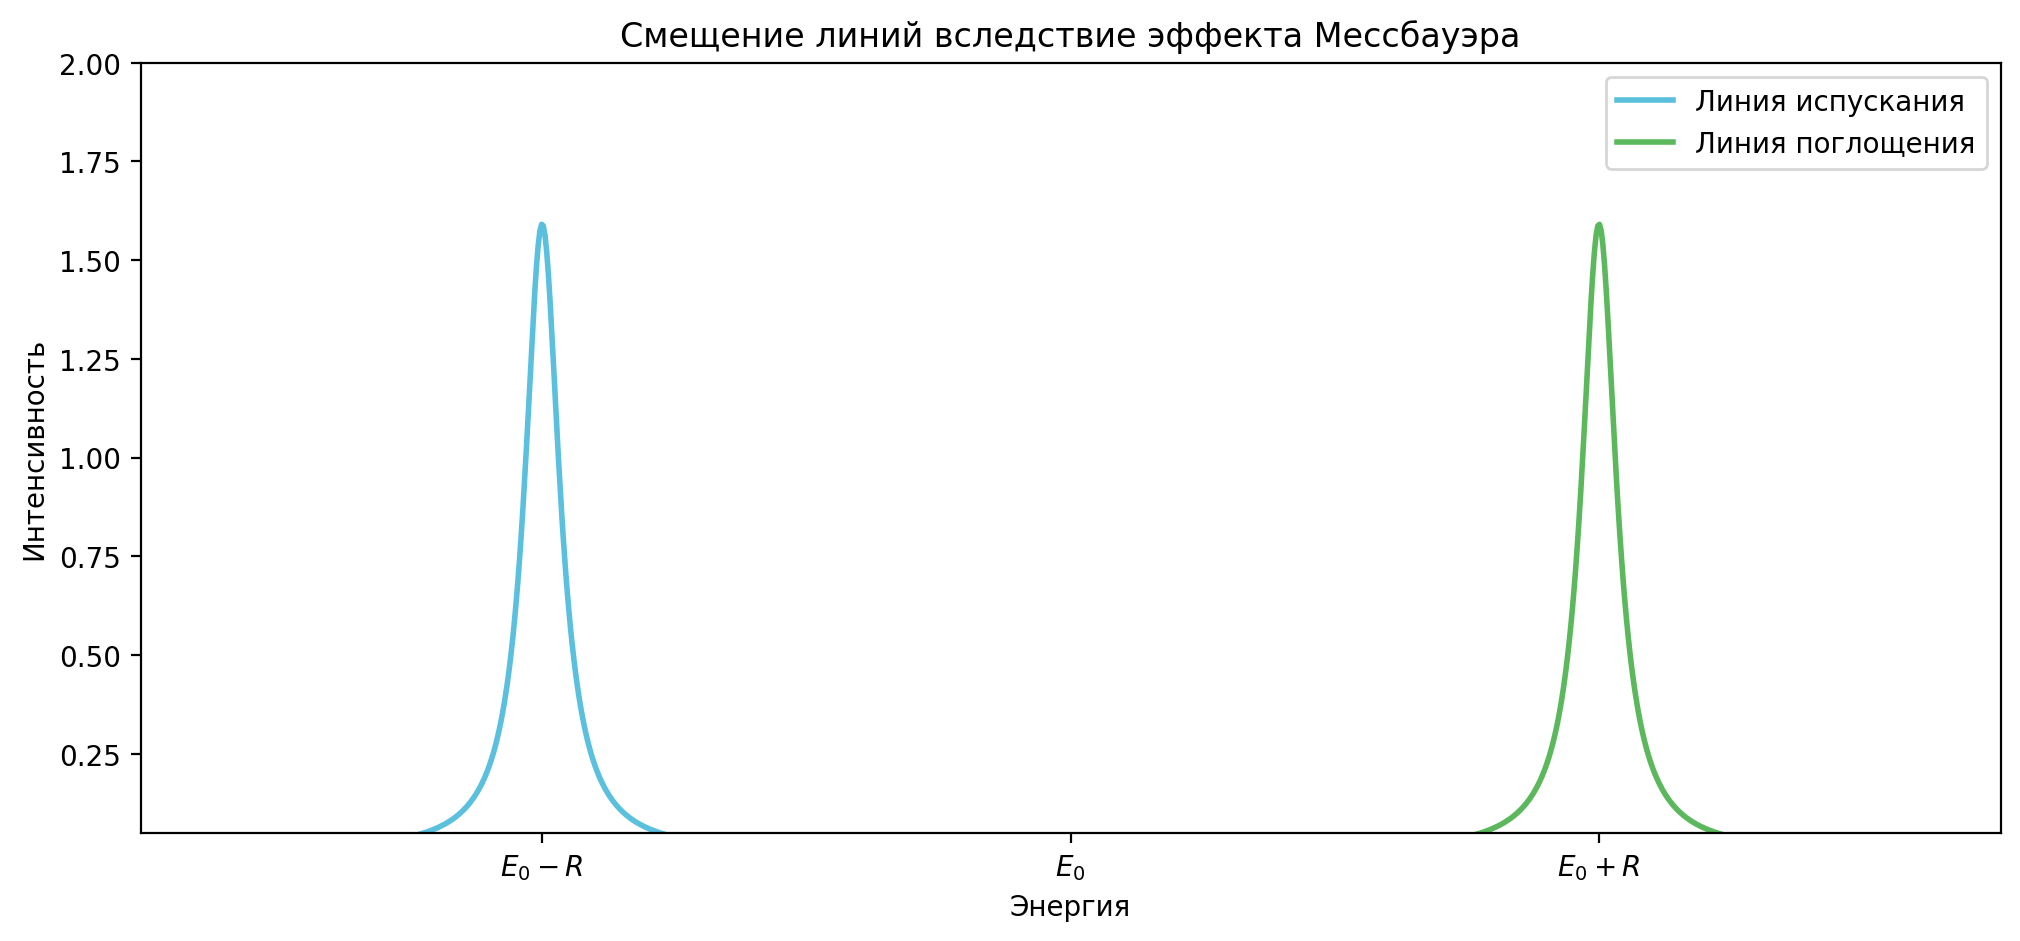

In [5]:
x_line = np.linspace(-8, 8, 1000)

fig = plt.figure(figsize = (12, 5), dpi = 200)
plt.plot(x_line, 
         sts.cauchy(loc = -5, scale = 0.2).pdf(x_line),
         color = [91 / 255,192 / 255,222 / 255],
         label = r'Линия испускания',
         linewidth = 2)
plt.plot(x_line, 
         sts.cauchy(loc = 5, scale = 0.2).pdf(x_line),
         color = [92 / 255, 184 / 255,92 / 255],
         label = r'Линия поглощения',
         linewidth = 2)
plt.xticks([-5, 0, 5], labels = [r'$E_{0} - R$', r'$E_{0}$', r'$E_{0} + R$'])
plt.ylim(0.05, 2)
plt.legend(loc = 'upper right')
tikzplotlib_fix_ncols(fig)
plt.xlabel("Энергия")
plt.ylabel("Интенсивность")
plt.title("Смещение линий вследствие эффекта Мессбауэра")
tikzplotlib.save(r"Отчет/lorenz.tex", dpi = 500)

### Основной эксперимент

In [4]:
colors = np.array([
    [66,139,202],
    [92,184,92],
    [91,192,222],
    [217,83,79],
]) / 255

In [5]:
def voigt_interpolation_func(x, amp, bias, offset, sigma, gamma):
    return offset - amp * voigt_profile(x + bias, sigma, gamma)

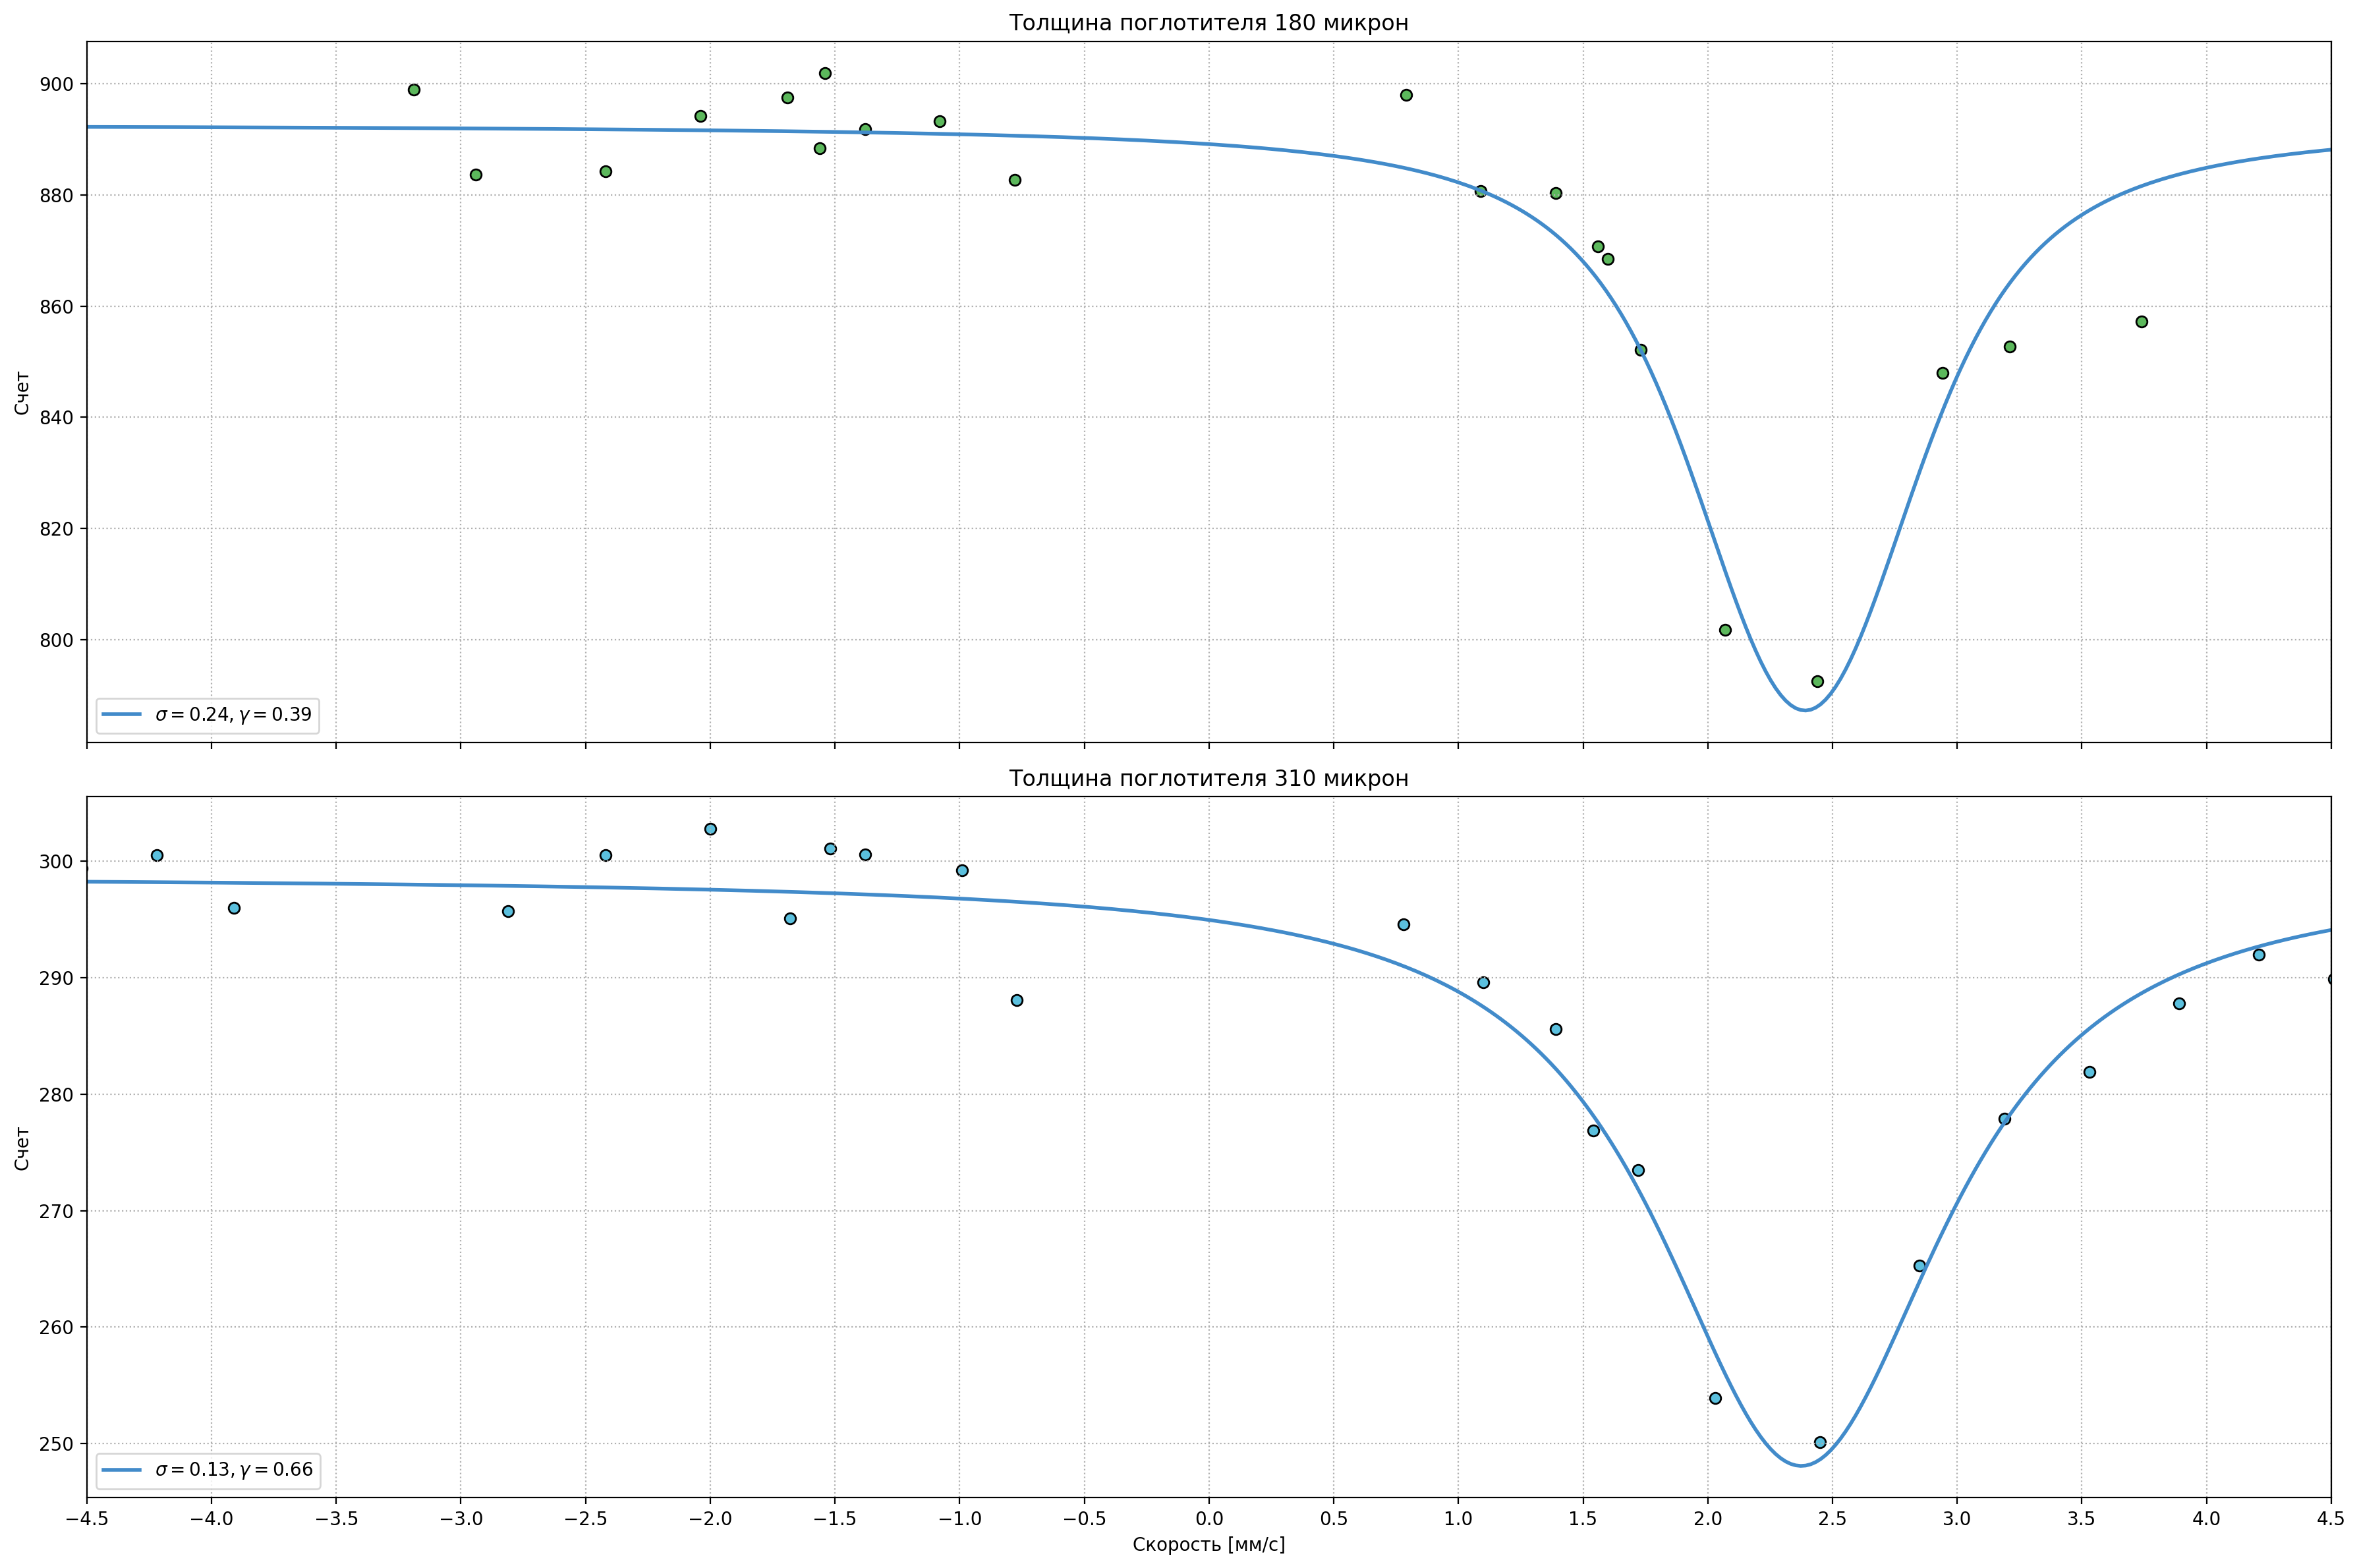

In [6]:
fig, ax = plt.subplots(2, 1, 
                       figsize = (18, 12),
                         dpi = 200,
                         sharex=True)
v_limits = [(-3.5, 4), (-6, 5)]
absorber_thickness = [180, 310] #толщина поглотителя(микрон)

for i, (plotable, lims, c, thik) in enumerate(zip(ax.ravel(), v_limits, colors[1:], absorber_thickness)):
    data = pd.read_csv(f"data/experiment_{i+2}.csv")
    data = data[(data['v'] > lims[0]) * (data['v'] < lims[1])]
    x_line = np.linspace(-10, 10, 1000)
    p0 = [100, -2.2, np.max(data.I), 0, 0.1]
    param, _ = optimize.curve_fit(f = voigt_interpolation_func, 
                                  xdata = data['v'],
                                  ydata =data['I'],
                                  maxfev = int(1e5),
                                  p0 = p0)
    plotable.plot(x_line, 
                  voigt_interpolation_func(x_line, *param),
                  linewidth = 2, 
                  color = colors[0],
                  label = f"$\sigma = {param[-2]:.2f}, \gamma = {param[-1]:.2f}$")
    plotable.scatter(data['v'], data['I'], color = c, edgecolors='black')
    plotable.set_ylabel("Счет")
    plotable.grid(ls = ':')
    plotable.set_title(f"Толщина поглотителя {thik} микрон")
    plotable.legend(loc = 'lower left')
ax[-1].set_xticks(np.arange(-5, 5, 0.5))
ax[-1].set_xlim(-4.5, 4.5)
ax[-1].set_xlabel("Скорость [мм/c]")


fig.tight_layout()
tikzplotlib_fix_ncols(fig)
tikzplotlib.save(r'Отчет/raw_data.tex', 
                 axis_height='5cm',
                 axis_width='18cm',
                 standalone = False,
                 encoding='utf-8',
                 strict = True)

In [7]:
def generate_sample(x_dens, p_dens, num):
    mean_dist = x_dens[1] - x_dens[0]
    print(mean_dist)
    return np.random.choice(x_dens, p = p_dens, size = num) + sts.uniform(loc = 0, scale = mean_dist).rvs(size = num)

In [8]:
lims = (-3.5, 4)

In [9]:
fig = plt.figure(figsize = (12, 5), dpi = 200)
data = pd.read_csv('data/experiment_2.csv')
data = data[(data['v'] > lims[0]) * (data['v'] < lims[1])]
data = data.sort_values(by = ['v'], ascending=True)
data.head()

,v,I
4,-3.19,898.9
5,-2.94,883.7
6,-2.42,884.2
7,-2.04,894.2
9,-1.69,897.5


<Figure size 2400x1000 with 0 Axes>

0.006936936936936977
(2.3592048819980134, 0.5617157221842497)
0.009489489489489245
(2.2412969197308406, 0.8643452605535762)


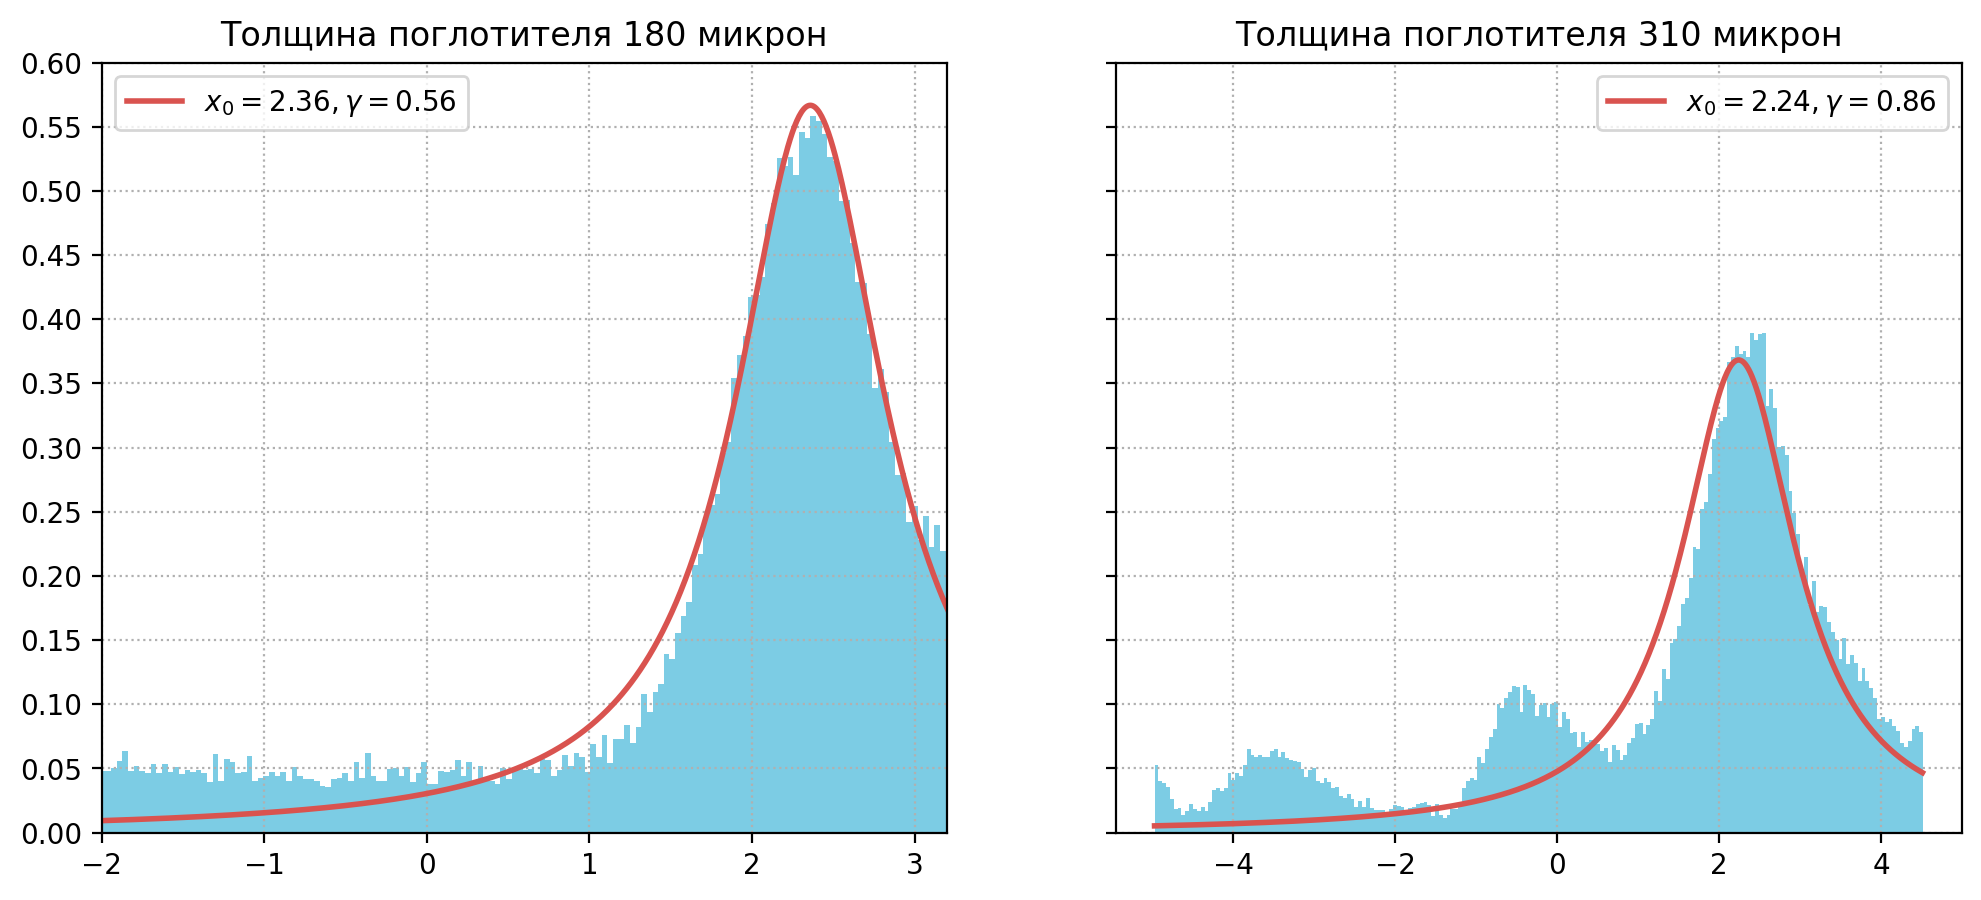

In [11]:
s_vals = [0.05, 0.03]
fig, ax = plt.subplots(1, 2, figsize = (12, 5), dpi = 200,
                       sharey=True)
for i, a, lims,s in zip([2, 3], ax, [(-3.5, 4), (-6.5, 5)], s_vals):
    data = pd.read_csv(f'data/experiment_{i}.csv')
    data = data[(data['v'] > lims[0]) * (data['v'] < lims[1])]
    data = data.sort_values(by = ['v'], ascending=True)
    data['I'] -= np.max(data['I'])
    data['I'] /= np.min(data['I'])

    x_line = np.linspace(np.min(data['v']), np.max(data['v']), 1000)
    f = interpolate.UnivariateSpline(data['v'], 
                                    data['I'], 
                                    s = s)
    x_points, p_points = x_line, f(x_line) / np.sum(f(x_line)) 
    sample  = generate_sample(x_points, p_points, 50000) 
    a.hist(sample,
        bins = 200,
        density=True,
        alpha = 0.8,
        color = colors[2])
    dist_param = sts.cauchy.fit(sample)
    print(dist_param)
    a.plot(x_line, sts.cauchy(*dist_param).pdf(x_line), 
                label = f'$x_0 = {dist_param[0]:.2f}, \gamma = {dist_param[1]:.2f}$', 
                color = colors[-1],
                linewidth = 2)
    a.legend()
    a.grid(ls = ':')
    a.set_yticks(np.arange(0, 1, 0.05))
    a.set_ylim(0, 0.6)
ax[0].set_xlim(-2, 3.2)
ax[0].set_title("Толщина поглотителя 180 микрон")
ax[1].set_title("Толщина поглотителя 310 микрон")
tikzplotlib_fix_ncols(fig)
tikzplotlib.save(r'Отчет/hist.tex',
                 axis_height='8cm',
                 axis_width='9cm',
                 standalone = False,
                 encoding='utf-8',
                 strict = True)